# Satisfacción de clientes

La satisfacción del cliente es un factor clave para el éxito de cualquier organización, especialmente en una entidad financiera, donde la insatisfacción puede llevar a que los clientes abandonen la empresa sin previo aviso. Detectar de manera temprana a estos clientes insatisfechos permitiría implementar estrategias proactivas que mejoren su experiencia y promuevan su fidelización.

El objetivo de este ejercicio es desarrollar un modelo que permita predecir, a partir de la variable binaria `TARGET`, la probabilidad de que un cliente esté insatisfecho.

## **Librerías y módulos**

In [36]:
import warnings
warnings.filterwarnings("ignore")
!pip install xgboost
!pip install imbalanced-learn
!pip install scikit-optimize
!pip install statsmodels


In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from collections import Counter
from xgboost import XGBClassifier
from IPython.display import display
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from skopt.space import Integer, Categorical, Real
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, accuracy_score)
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

## **EDA: Análisis Exploratorio de los Datos**

En primer lugar, procedemos a importar la base de datos de entrenamiento proporcionada.

In [38]:
from google.colab import drive
import pandas as pd

# Montar Google Drive
drive.mount('/content/drive')

# Especificar la ruta al archivo en tu Google Drive
file_path = '/content/drive/My Drive/train.csv'

# Cargar el archivo en un DataFrame
datatrain = pd.read_csv(file_path)

# Visualiza los datos
datatrain.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [39]:
datatrain.shape

(76020, 371)

El conjunto de datos **Satisfacción de Clientes** contiene `76,020` observaciones anonimizadas con `371` variables numéricas y una columna `TARGET`, que clasifica a los clientes en satisfechos (`0`) o insatisfechos (`1`). Este análisis busca desarrollar modelos predictivos para anticipar la insatisfacción y mejorar la relación con los clientes.

Sobre las variables, dado que son datos financieros, no tenemos conocimiento relacionado con qué corresponde cada una. Por esta razón, en esta ocasión, no contaremos con un diccionario para estas.

Ahora, comprobemos el tipo de las variables.

In [40]:
datatrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


Tal como se esperaba, todas son de tipo numérico, siendo la variable objetivo `TARGET` binaria. Por lo tanto, podemos observar el comportamiento de estas a partir de estadísticas descriptivas.

In [41]:
datatrain.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


De manera general, se observa una alta variabilidad en muchas de las variables. Esto es evidente al comparar la media con la desviación estándar, que en algunos casos es considerablemente mayor que la media. Por ejemplo, en la variable `imp_ent_var16_ult1`, la media es de `86.2`, mientras que la desviación estándar alcanza `1614`. Otro caso notable es `saldo_medio_var44_ult1`, cuya media es de `76` y su desviación estándar de `4040`. Este comportamiento puede atribuirse a la marcada diferencia entre los valores mínimos y máximos de estas variables, que, a simple vista, están muy alejados entre sí y que, a su vez, parecen indicar presencia de datos atípicos.

Además, se identifica una tendencia destacada en la que los tres cuartiles toman el valor 0, un patrón que también parece reflejarse en la variable objetivo. Este comportamiento podría ser un indicio de desbalance en los datos, un aspecto que será analizado más detalladamente más adelante.

Analicemos ahora la presencia de datos faltantes, los cuales aparentan no existir.

### **Detección de datos faltantes**

In [42]:
na = datatrain.isnull().sum().reset_index()  # Contar datos faltantes
na.columns = ['Columna', 'Cantidad de Datos Faltantes']

# Calcular el porcentaje de datos faltantes
na['Porcentaje de Datos Faltantes'] = (na['Cantidad de Datos Faltantes'] / len(datatrain)) * 100
na['Porcentaje de Datos Faltantes'] = na['Porcentaje de Datos Faltantes'].map('{:.2f}%'.format)

tabla1 = na.style.set_table_attributes('style="width: 80%; margin: auto;"') \
    .set_caption("Datos Faltantes por Columna") \
    .background_gradient(cmap='Blues') \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'white'), ('color', 'black'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('padding', '10px')]}
    ])
display(tabla1)

,Columna,Cantidad de Datos Faltantes,Porcentaje de Datos Faltantes
0,ID,0,0.00%
1,var3,0,0.00%
2,var15,0,0.00%
3,imp_ent_var16_ult1,0,0.00%
4,imp_op_var39_comer_ult1,0,0.00%
5,imp_op_var39_comer_ult3,0,0.00%
6,imp_op_var40_comer_ult1,0,0.00%
7,imp_op_var40_comer_ult3,0,0.00%
8,imp_op_var40_efect_ult1,0,0.00%
9,imp_op_var40_efect_ult3,0,0.00%


Ya podemos afirmar con certeza que, en efecto, ninguna de las variables, tanto explicativas como objetivo, cuenta con datos faltantes.

Seguiremos entonces con el análisis de las variables de nuestro conjunto de datos.

### **Análisis de las variables**

Antes de comenzar con el respectivo análisis, veamos el nombre de todas estas.

In [43]:
datatrainexp = datatrain.drop(columns=["TARGET"])
datatrainexp.columns.tolist()


['ID',
 'var3',
 'var15',
 'imp_ent_var16_ult1',
 'imp_op_var39_comer_ult1',
 'imp_op_var39_comer_ult3',
 'imp_op_var40_comer_ult1',
 'imp_op_var40_comer_ult3',
 'imp_op_var40_efect_ult1',
 'imp_op_var40_efect_ult3',
 'imp_op_var40_ult1',
 'imp_op_var41_comer_ult1',
 'imp_op_var41_comer_ult3',
 'imp_op_var41_efect_ult1',
 'imp_op_var41_efect_ult3',
 'imp_op_var41_ult1',
 'imp_op_var39_efect_ult1',
 'imp_op_var39_efect_ult3',
 'imp_op_var39_ult1',
 'imp_sal_var16_ult1',
 'ind_var1_0',
 'ind_var1',
 'ind_var2_0',
 'ind_var2',
 'ind_var5_0',
 'ind_var5',
 'ind_var6_0',
 'ind_var6',
 'ind_var8_0',
 'ind_var8',
 'ind_var12_0',
 'ind_var12',
 'ind_var13_0',
 'ind_var13_corto_0',
 'ind_var13_corto',
 'ind_var13_largo_0',
 'ind_var13_largo',
 'ind_var13_medio_0',
 'ind_var13_medio',
 'ind_var13',
 'ind_var14_0',
 'ind_var14',
 'ind_var17_0',
 'ind_var17',
 'ind_var18_0',
 'ind_var18',
 'ind_var19',
 'ind_var20_0',
 'ind_var20',
 'ind_var24_0',
 'ind_var24',
 'ind_var25_cte',
 'ind_var26_0',
 '

Ahora, eliminaremos la variable `ID` del conjunto de datos pues esta no brinda ningún tipo de información a nuestro ejercicio de interés.

In [44]:
datatrainexp = datatrainexp.drop(columns=["ID"])
datatrainexp

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000
1,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000
2,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000
3,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000
4,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,2,48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60926.490000
76016,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118634.520000
76017,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74028.150000
76018,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84278.160000


#### **Reducción de dimensionalidad**

Como científicas de datos, hemos decidido implementar un proceso de **reducción de dimensionalidad**. Este proceso tiene como objetivo seleccionar únicamente aquellas variables que expliquen la mayor parte de la variabilidad de los datos.

Dado que contamos con un gran número de variables explicativas, comenzaremos evaluando la **multicolinealidad** mediante una alternativa al cálculo del **Factor de Inflación de la Varianza (VIF)** dado su alto costo computacional. Debido al tamaño de la base de datos, con `369` variables, el cálculo iterativo del VIF resulta computacionalmente costoso, lo que lo hace inviable en términos de tiempo y recursos. Por ello, hemos optado por una alternativa basada en la **matriz de correlación**, que permite identificar y eliminar variables redundantes de manera eficiente al establecer un umbral de correlación de `0.8`, valor a partir del cual se considera correlación alta. Este enfoque reduce la multicolinealidad con un costo computacional significativamente menor.

Posteriormente, aplicaremos el **PCA** como una técnica de reducción de dimensionalidad. Este nos permitirá transformar las variables originales en un conjunto más pequeño de componentes principales, garantizando que estas capturen la mayor parte de la variabilidad presente en los datos originales. Para determinar el número óptimo de componentes principales a incluir, utilizaremos el **método del codo** como criterio visual. Asimismo, estableceremos como criterio adicional que las componentes seleccionadas deben explicar al menos el **95% de la variabilidad total** del conjunto de datos, asegurando así que la información clave sea retenida mientras reducimos significativamente la complejidad.


##### **MULTICOLINEALIDAD**

Comencemos observando por medio de la matriz de correlación, qué tan relacionadas están algunas variables de este conjunto de datos entre sí.

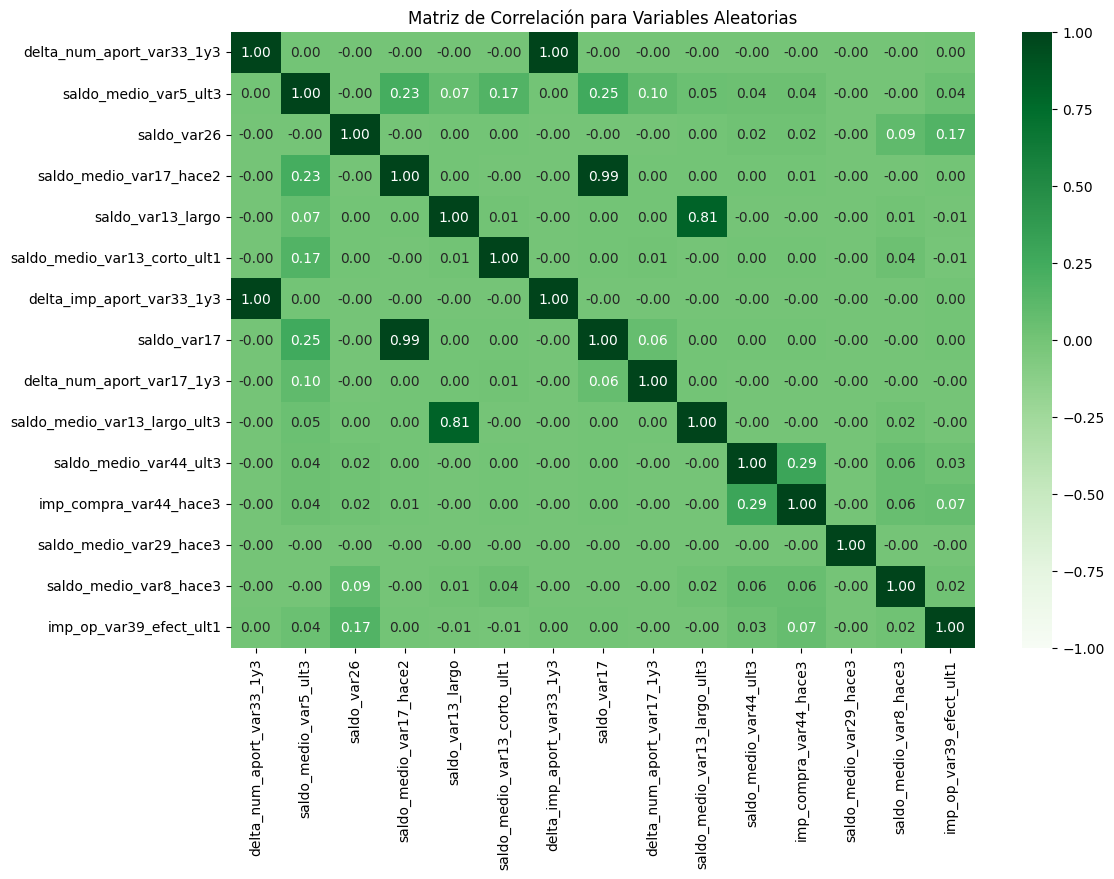

In [45]:
solofloat = datatrainexp.select_dtypes(include=['float64'])

num_variables = 15
variablesrandom = solofloat.sample(n=num_variables, axis=1, random_state=21)

matrizcorrelacion = variablesrandom.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(matrizcorrelacion, annot=True, fmt=".2f", cmap='Greens', vmin=-1, vmax=1)
plt.title('Matriz de Correlación para Variables Aleatorias')
plt.show()


Es evidente que hay variables que cuentan con correlaciones altas entre sí, por esta razón procederemos a eliminar aquellas que afecten a los modelos debido a esta alta colinealidad.

In [46]:
matricescorrelacion = datatrainexp.corr().abs()
upper_triangle = matricescorrelacion.where(
    np.triu(np.ones(matricescorrelacion.shape), k=1).astype(bool)
)
umbral = 0.8

correlacionadasaltas = [
    column for column in upper_triangle.columns if any(upper_triangle[column] > umbral)
]

print(f"Variables a eliminar: {correlacionadasaltas}")

datareducida = datatrainexp.drop(columns=correlacionadasaltas)

print(f"Número de variables restantes: {datareducida.shape[1]}")

Variables a eliminar: ['imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult3', 'imp_op_var41_comer_ult1', 'imp_op_var41_comer_ult3', 'imp_op_var41_efect_ult3', 'imp_op_var41_ult1', 'imp_op_var39_efect_ult1', 'imp_op_var39_efect_ult3', 'imp_op_var39_ult1', 'ind_var8_0', 'ind_var8', 'ind_var12', 'ind_var13_corto_0', 'ind_var13_corto', 'ind_var13_largo', 'ind_var13_medio', 'ind_var13', 'ind_var17', 'ind_var18', 'ind_var20', 'ind_var24_0', 'ind_var24', 'ind_var26_0', 'ind_var26_cte', 'ind_var26', 'ind_var25_0', 'ind_var25', 'ind_var29_0', 'ind_var29', 'ind_var30', 'ind_var31', 'ind_var32_0', 'ind_var32', 'ind_var33', 'ind_var34', 'ind_var37_0', 'ind_var37', 'ind_var40_0', 'ind_var40', 'ind_var41_0', 'ind_var39', 'ind_var44', 'num_var1_0', 'num_var1', 'num_var5_0', 'num_var5', 'num_var6_0', 'num_var6', 'num_var8_0', 'num_var8', 'num_var12_0', 'num_var12', 'num_var13_0', 'num_var13_corto_0', 'num_var13_corto', 'num_var13_largo_0', 'num_var13_largo', 'num_var13_medio_

##### **PCA**

Componentes necesarios para explicar el 95% de la varianza: 94


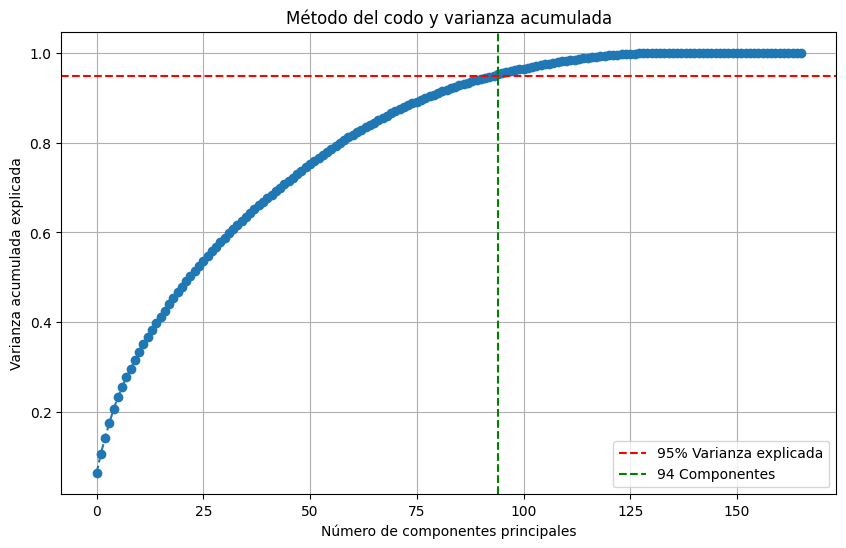

In [47]:
scaler = StandardScaler()
datanormalizada = scaler.fit_transform(datareducida)

pca = PCA() # PCA sin limitar componentes (para análisis inicial)
datatrainexp_pca = pca.fit_transform(datanormalizada)

acumvar = np.cumsum(pca.explained_variance_ratio_) # Analizar la varianza explicada

# Encontrar el número de componentes para el 95% de varianza
n_components_95 = np.argmax(acumvar >= 0.95) + 1
print(f"Componentes necesarios para explicar el 95% de la varianza: {n_components_95}")

plt.figure(figsize=(10, 6))
plt.plot(acumvar, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Varianza explicada")
plt.axvline(x=n_components_95, color='g', linestyle='--', label=f"{n_components_95} Componentes")
plt.title("Método del codo y varianza acumulada")
plt.xlabel("Número de componentes principales")
plt.ylabel("Varianza acumulada explicada")
plt.legend()
plt.grid()
plt.show()

Como resultado de lo anterior, seguiremos trabajando con `94 componentes principales` en lugar de las `371` variables originales. Estas `94` son combinaciones lineales de las variables originales que explican, como mínimo, el `95%` de la variabilidad presente en los datos. Estas representan las características más relevantes para retener la mayor parte de la información del conjunto de datos y serán mostradas en la siguiente tabla ordenadas de mayor a menor de acuerdo con su contribución.

In [48]:
pca_optimal = PCA(n_components=94)  # Ajustar PCA con 93 componentes principales
datatrainexp_pca_optimal = pca_optimal.fit_transform(datanormalizada)

# Varianza explicada por los 93 componentes principales
explained_variance = pca_optimal.explained_variance_ratio_
print("Proporción de varianza explicada por los primeros 94 componentes principales:")
print(explained_variance)

# Componentes principales obtenidos del PCA
components = pca_optimal.components_

# Crear DataFrame de las contribuciones de las variables originales a los componentes principales
contributions = pd.DataFrame(
    components.T,  # Transponer para tener variables originales como filas
    index=datareducida.columns,  # Variables originales como índice
    columns=[f'PC{i+1}' for i in range(94)]  # Nombres de los componentes principales
)

# Calcular la contribución total (magnitud absoluta sumada por fila)
contribucion = contributions.abs().sum(axis=1).sort_values(ascending=False).head(94)

# Crear un DataFrame con las contribuciones totales
contribucion_df = pd.DataFrame(contribucion, columns=['Contribución Total'])


tabla2 = contribucion_df.style.set_table_attributes('style="margin: auto;"') \
    .set_caption("Contribución de las variables a los componentes principales") \
    .background_gradient(cmap='Greens') \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'white'), ('color', 'black'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('padding', '5px')]}
    ]) \
    .set_properties(**{'text-align': 'center'})
display(tabla2)



Proporción de varianza explicada por los primeros 94 componentes principales:
[0.06258901 0.0422381  0.0373341  0.03238024 0.0310354  0.02650813
 0.02372108 0.02043857 0.01986086 0.01861481 0.01814772 0.0171503
 0.01627293 0.01560474 0.01502736 0.01491168 0.01386365 0.01373939
 0.01353157 0.01306902 0.01270847 0.01251377 0.01185112 0.01124512
 0.01120045 0.01088474 0.01068664 0.01048939 0.0102403  0.01013747
 0.0099338  0.00981317 0.00945441 0.00931247 0.0092203  0.00908921
 0.00895698 0.00843119 0.00824141 0.00801319 0.00784172 0.00778877
 0.00773455 0.00768561 0.00763553 0.00762032 0.0076054  0.00757091
 0.00753564 0.00746624 0.00736378 0.00717248 0.00705552 0.007038
 0.00672617 0.00662553 0.00653525 0.00635088 0.00613201 0.00604205
 0.00582081 0.00577232 0.00555192 0.0054812  0.00545836 0.00524843
 0.00511875 0.0050727  0.005016   0.00495473 0.00463743 0.00459546
 0.00448576 0.00442775 0.00438626 0.00415844 0.00406991 0.00387326
 0.00381342 0.00365586 0.00358187 0.0035495  0.0034205

,Contribución Total
saldo_var5,7.100018
ind_var30_0,7.078362
saldo_medio_var12_hace3,7.024193
var15,6.917673
saldo_medio_var8_hace3,6.765636
saldo_var14,6.638598
saldo_medio_var5_hace2,6.598843
num_var22_ult1,6.578568
num_var37_med_ult2,6.441215
imp_op_var41_efect_ult1,6.427983


In [49]:
datatrainexp_pca_optimal

array([[-1.92479267,  0.09281693,  0.160117  , ..., -0.00413467,
        -0.01103806,  0.09516888],
       [ 0.47348802,  3.13861909, -0.53530793, ..., -0.91373587,
        -0.65344769,  1.10694557],
       [-1.59670176, -0.08443812,  0.12269445, ...,  0.12433445,
         0.11523321, -0.46015622],
       ...,
       [-1.5964781 , -0.08410576,  0.12283289, ...,  0.12422306,
         0.11524008, -0.46020079],
       [-1.57291169, -0.07096593,  0.12237989, ...,  0.12110099,
         0.11212983, -0.45987714],
       [-1.65528389,  0.24165522,  0.15398194, ..., -0.03940353,
        -0.04677999,  0.0990432 ]])

In [50]:
# Generación de nuevo dataset con variables con alta variabilidad
variablespca = contribucion.index.tolist()
variables = variablespca
datatrainfinal = datareducida[variables]
datatrainfinal

,saldo_var5,ind_var30_0,saldo_medio_var12_hace3,var15,saldo_medio_var8_hace3,saldo_var14,saldo_medio_var5_hace2,num_var22_ult1,num_var37_med_ult2,imp_op_var41_efect_ult1,...,ind_var17_0,ind_var1_0,imp_trasp_var17_in_ult1,num_var17_0,delta_imp_trasp_var17_out_1y3,delta_imp_reemb_var17_1y3,saldo_var13_largo,num_op_var41_ult1,saldo_var30,num_var4
0,0.00,1,0.0,23,0.0,0.0,0.00,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0,0.00,0
1,0.00,1,0.0,34,0.0,0.0,0.00,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0,300.00,1
2,3.00,1,0.0,23,0.0,0.0,3.00,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0,3.00,1
3,70.62,1,0.0,37,0.0,0.0,186.09,0,6,0.0,...,0,0,0.0,0,0,0,0.0,9,70.62,3
4,0.00,1,0.0,39,0.0,0.0,3.00,6,0,0.0,...,0,0,0.0,0,0,0,0.0,0,135003.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,0.00,1,0.0,48,0.0,0.0,0.00,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0,0.00,0
76016,0.00,1,0.0,39,0.0,0.0,130.65,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0,48191.22,1
76017,3.00,1,0.0,23,0.0,0.0,3.00,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0,3.00,1
76018,3.00,1,0.0,25,0.0,0.0,3.00,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0,3.00,1


#### **Análisis univariado**

Como parte del seguimiento de este proceso, seleccionaremos `10` variables de las `94` disponibles para realizar un análisis detallado de cada una y, posteriormente, un análisis de las relaciones entre ellas.

* **Variables explicativas**

Aquí, graficaremos las distribuciones de los datos para comprender el comportamiento de cada una de ellas y poder realizar los respectivos análisis.

In [51]:
best10 = variables[:10]
best10= datatrainfinal[best10]

 **Boxplots**

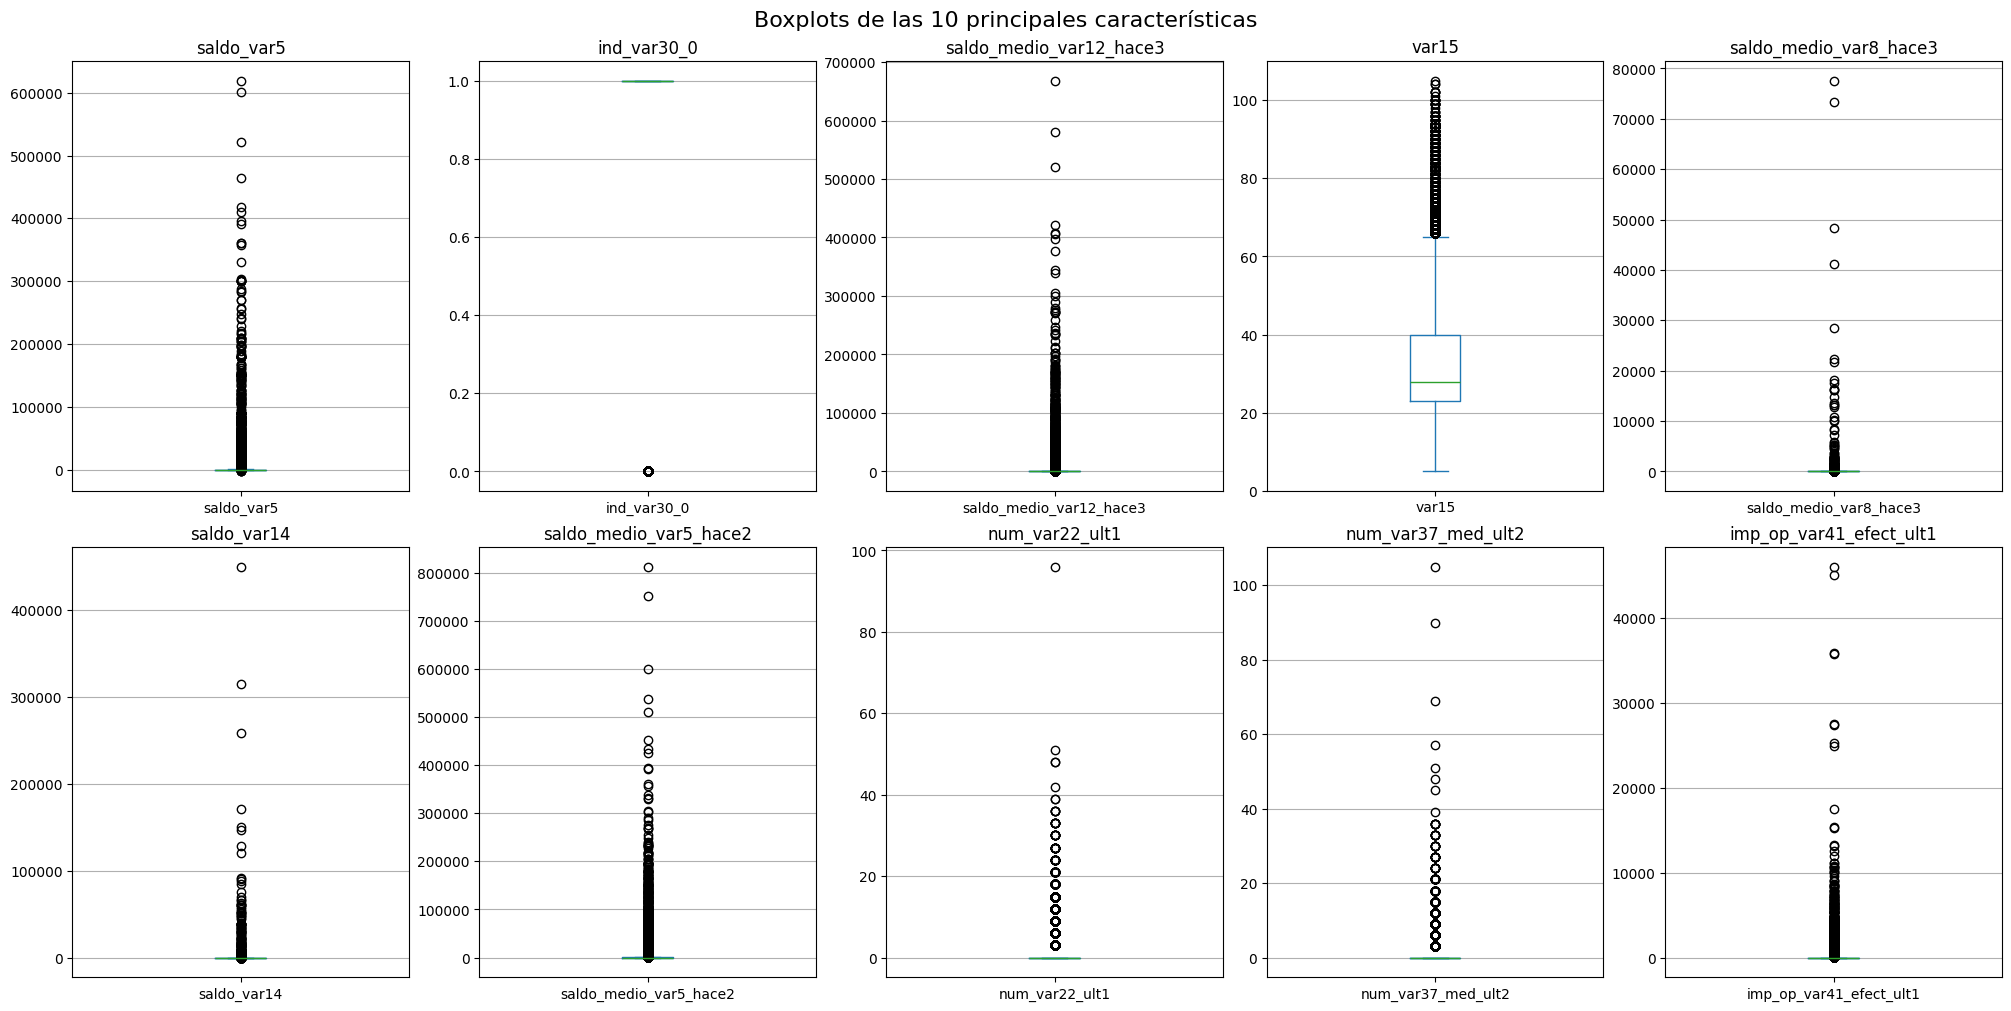

In [52]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10), constrained_layout=True)

for ax, variable in zip(axes.flat, best10):
    best10[variable].plot(kind='box', ax=ax, vert=True)
    ax.set_title(variable)
    ax.grid(axis='y')

plt.suptitle("Boxplots de las 10 principales características", fontsize=16)
plt.show()

Es evidente la presencia de numerosos datos atípicos en esta base de datos, algo que ya se había anticipado a partir de las estadísticas descriptivas iniciales, las cuales revelaban una alta variabilidad en los datos.

Además, se aprecia que la mayoría de las variables, con excepción de `var15` e `ind_var30_0`, concentran la mayoría de sus valores en `0`. Esto se traduce en boxplots que prácticamente no muestran cajas, ya que los bigotes y los cuartiles coinciden en el valor `0`.

Sin embargo, la variable `ind_var30_0` muestra un comportamiento similar, aunque en este caso los valores están concentrados en `1`.

Por otro lado, la variable `var15` muestra un comportamiento diferente, caracterizado por una mayor variabilidad y un rango más amplio de valores. Esto sugiere que podría contener información más relevante para el análisis. Procedamos a estudiarla más a fondo.

In [53]:
best10['var15'].describe()

,var15
count,76020.000000
mean,33.212865
std,12.956486
min,5.000000
25%,23.000000
50%,28.000000
75%,40.000000
max,105.000000


Esta variable presenta una media de `33.21` y una desviación estándar de aproximadamente `13`. Su valor mínimo es `5` y el máximo `105`, lo que indica que los datos extremos son relativamente cercanos en comparación con las demás variables analizadas.


Se observa que la mayor variabilidad ocurre en el primer y último `25%` de los datos (es decir, los extremos), donde los bigotes son un poco extensos. En cuanto a los datos dentro de la caja, el segundo `25%` (entre el primer cuartil `23` y el segundo cuartil o mediana `28`) está más concentrado, mientras que los datos entre la mediana y el tercer cuartil (`28` y `40`, respectivamente) muestran una mayor dispersión.


**Histogramas**

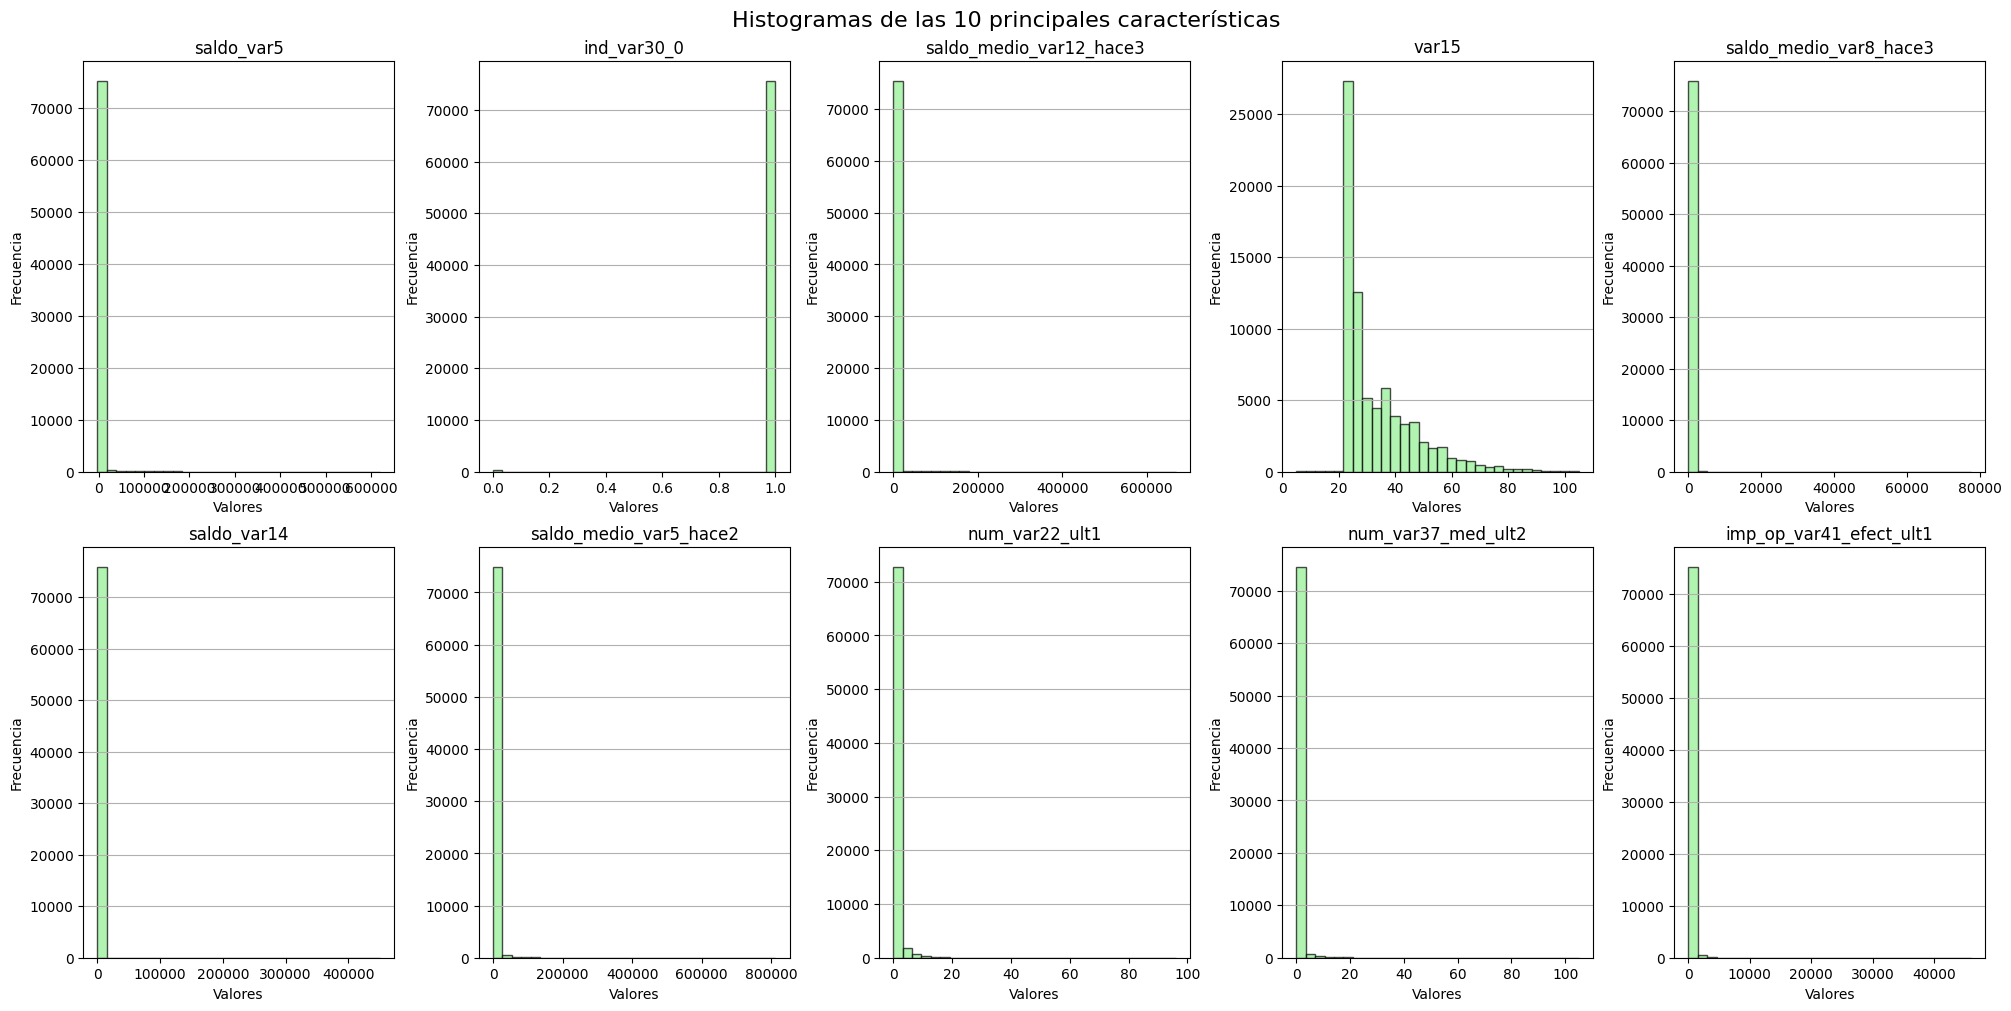

In [54]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10), constrained_layout=True)

for ax, variable in zip(axes.flat, best10):
    best10[variable].plot(kind='hist', ax=ax, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    ax.set_title(variable)
    ax.set_xlabel("Valores")
    ax.set_ylabel("Frecuencia")
    ax.grid(axis='y')

plt.suptitle("Histogramas de las 10 principales características", fontsize=16)
plt.show()


Las gráficas muestran que las variables no siguen una distribución normal, lo cual era esperado, y tampoco son simétricas. En particular, muchas variables concentran una gran cantidad de valores cerca de `0`, mientras que los valores más altos son significativamente menos frecuentes, lo que indica un patrón de distribución altamente desigual.

Por otro lado, `var15`, presenta una mayor dispersión, indicando una distribución más heterogénea en comparación con otras. Sin embargo, en general, el patrón predominante es el de colas largas hacia valores altos, lo que evidencia la existencia de valores extremos que afectan la distribución.

* **Variable objetivo**

Lo primero que haremos es calcular la cantidad de clientes que corresponden a las dos clases, es decir, persona satisfecha (`0`) o persona insatisfecha (`1`).

In [55]:
conteo = datatrain['TARGET'].value_counts()
porcentaje = datatrain['TARGET'].value_counts(normalize=True) * 100

resumen = pd.DataFrame({
    'Clase': conteo.index,
    'Cantidad': conteo.values,
    'Porcentaje': porcentaje.values
})

resumen


,Clase,Cantidad,Porcentaje
0,0,73012,96.043147
1,1,3008,3.956853


Veamos esto gráficamente.

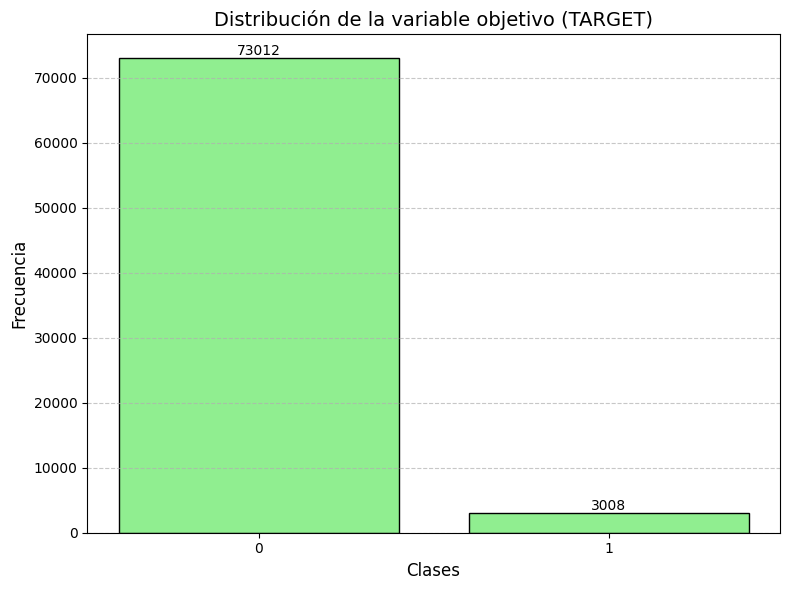

In [56]:
frecuencia = datatrain['TARGET'].value_counts()

plt.figure(figsize=(8, 6))
bars = plt.bar(frecuencia.index, frecuencia.values, color='lightgreen', edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{int(height)}', ha='center', va='bottom')
plt.title('Distribución de la variable objetivo (TARGET)', fontsize=14)
plt.xlabel('Clases', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(frecuencia.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Tanto la tabla mostrada antes como el gráfico, muestran la distribución de la variable objetivo `TARGET`, la cual es binaria. Se observa un claro desbalance en las clases: la clase `0`, correspondiente a los clientes satisfechos, tiene una frecuencia significativamente mayor con `73,012` observaciones, mientras que la clase `1`, asociada a los clientes insatisfechos, cuenta con únicamente `3,008` observaciones. Esto indica que la mayoría de los datos representan a clientes satisfechos, mientras que los insatisfechos son una minoría en esta base de datos.

#### **Análisis bivariado**

* **Scatterplot**

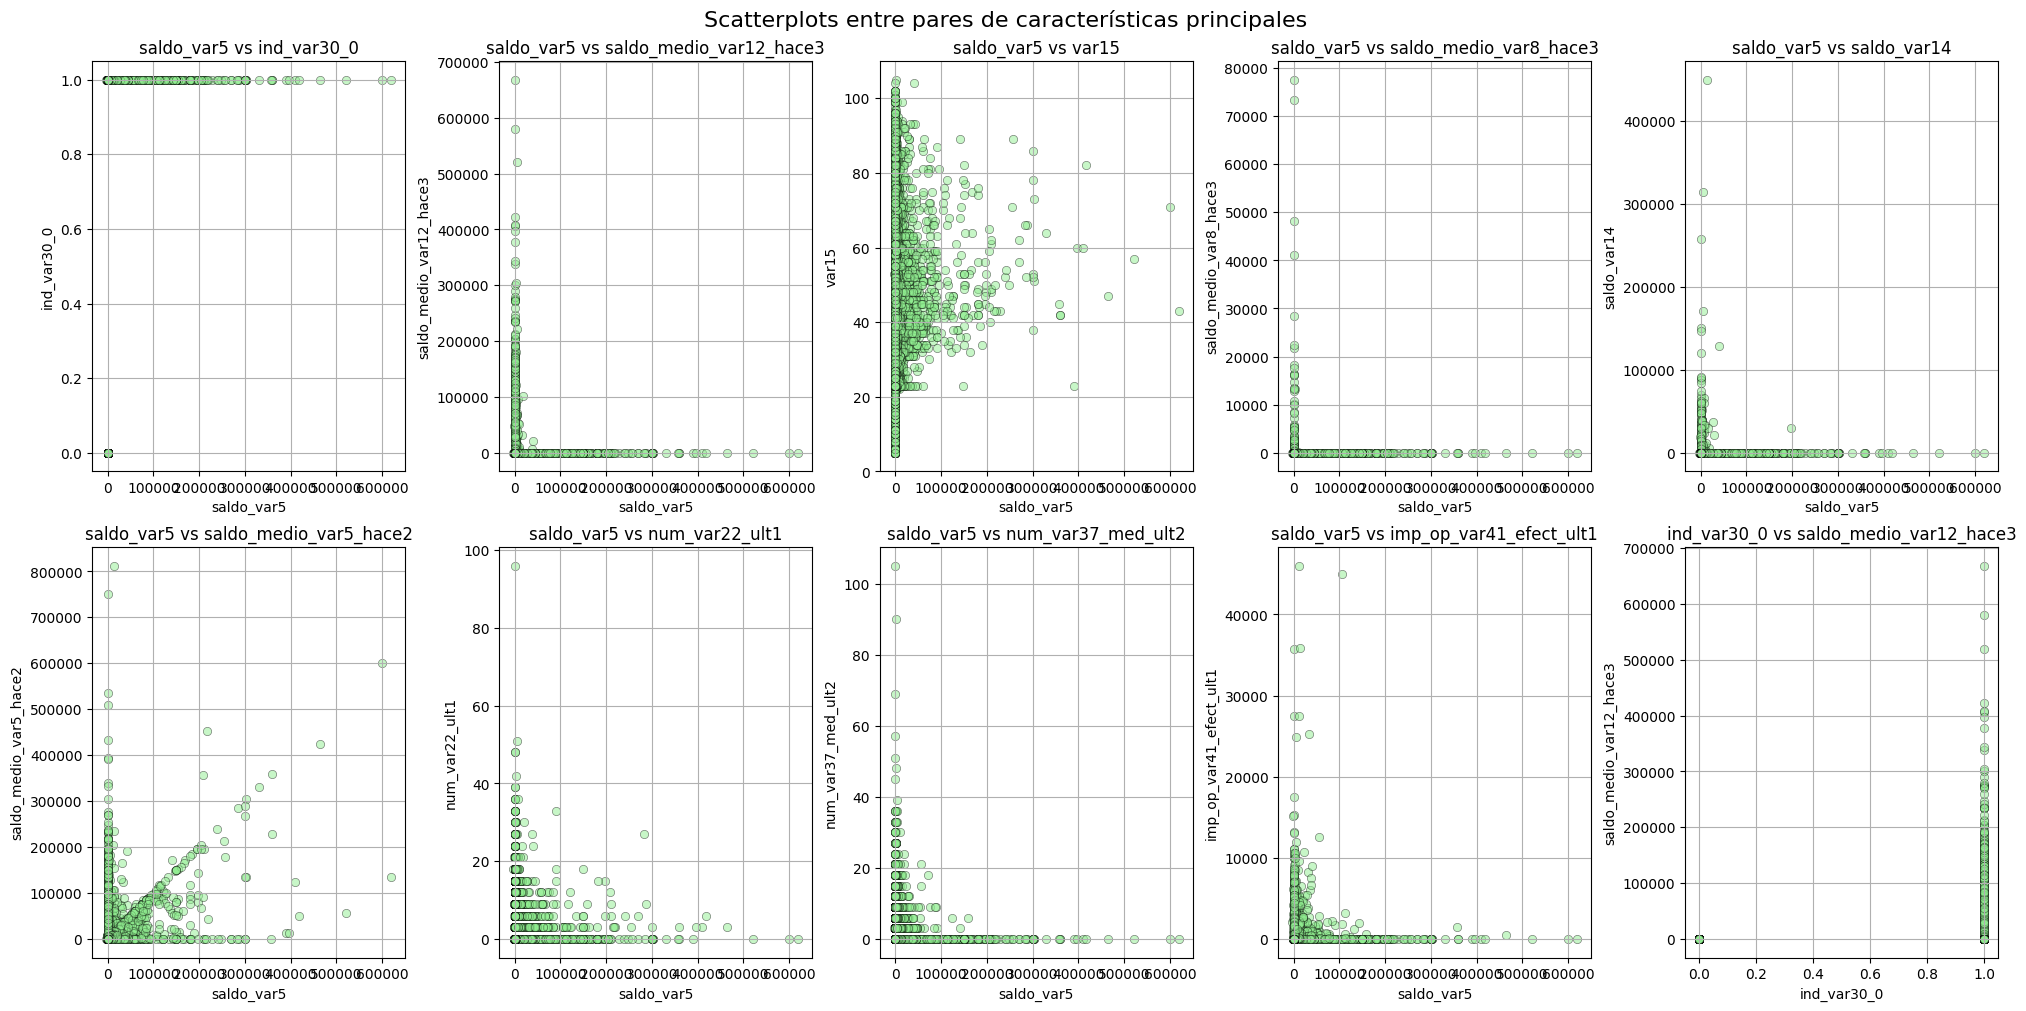

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Crear combinaciones de pares de características
pairs = list(itertools.combinations(best10, 2))

# Crear una figura con subplots
fig, axes = plt.subplots(2, 5, figsize=(20, 10), constrained_layout=True)

# Iterar sobre las combinaciones y los ejes
for ax, (x_feature, y_feature) in zip(axes.flat, pairs):
    sns.scatterplot(
        x=x_feature,
        y=y_feature,
        data=best10,
        ax=ax,
        alpha=0.5,
        color='lightgreen',
        edgecolor='black'
    )
    ax.set_title(f"{x_feature} vs {y_feature}")
    ax.set_xlabel(x_feature)
    ax.set_ylabel(y_feature)
    ax.grid()

# Título general
plt.suptitle("Scatterplots entre pares de características principales", fontsize=16)
plt.show()

De manera general, se puede observar que los datos están mayormente concentrados en los valores más bajos en cada gráfico, lo cual coincide con los patrones previamente mencionados.

En las gráficas correspondientes a `saldo_var5 vs. ind_var30_0` e i`nd_var30_0 vs. saldo_medio_var12_hace3`, no se evidencia una relación lineal significativa entre las variables analizadas.

Por otro lado, en la mayoría de los gráficos restantes, se aprecia una marcada tendencia de concentración de valores cercanos a cero. Una excepción a este patrón es la gráfica de `saldo_var5 vs. saldo_medio_var5_hace2`, donde se observa una ligera correlación positiva, lo que indica una relación más estrecha entre estas dos variables.

* **Regplot**

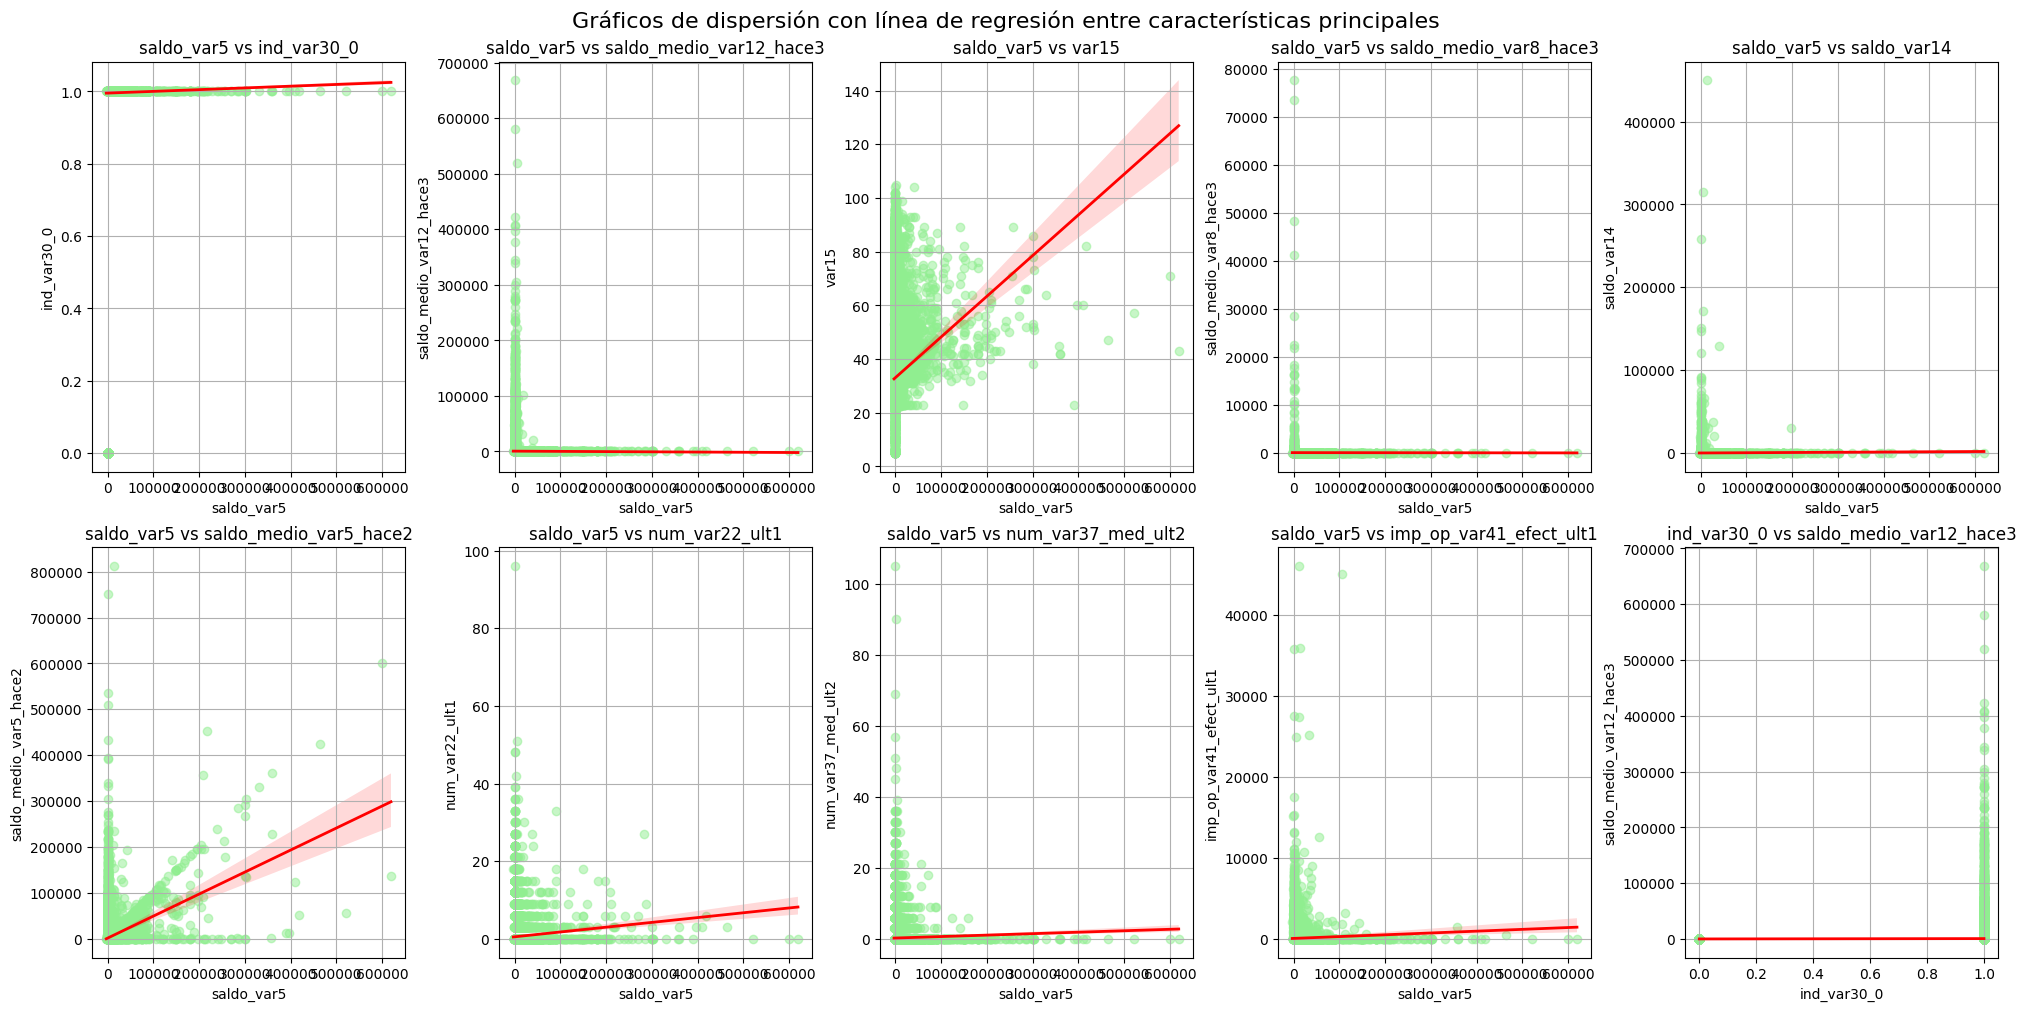

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Crear combinaciones de pares de características
pairs = list(itertools.combinations(best10, 2))

fig, axes = plt.subplots(2, 5, figsize=(20, 10), constrained_layout=True)

# Asegúrate de que el número de pares no sea mayor que el número de subplots
for ax, (var_x, var_y) in zip(axes.flat, pairs):
    sns.regplot(
        x=var_x,
        y=var_y,
        data=best10,
        ax=ax,
        scatter_kws={'alpha': 0.5, 'color': 'lightgreen'},
        line_kws={'color': 'red', 'linewidth': 2}
    )
    ax.set_title(f"{var_x} vs {var_y}")
    ax.set_xlabel(var_x)
    ax.set_ylabel(var_y)
    ax.grid()

plt.suptitle("Gráficos de dispersión con línea de regresión entre características principales", fontsize=16)
plt.show()


Los gráficos revelan patrones variados entre las variables principales. Destaca una correlación lineal positiva entre `saldo_var5 y var15`, mientras que en pares como `saldo_var5 vs saldo_medio_var12_hace3` y `saldo_var5 vs num_var37_med_ult2` la relación es débil o nula. La mayoría de los datos están concentrados cerca del origen, reflejando valores bajos predominantes, aunque se observa una correlación moderada en `saldo_var5 vs saldo_medio_var5_hace2`.

Finalmente, luego de terminar este análisis exploratorio, nos quedamos con este conjunto de datos.

### **Data final**

In [59]:
datafinal = pd.concat([datatrainfinal, datatrain['TARGET']], axis=1)
datafinal

,saldo_var5,ind_var30_0,saldo_medio_var12_hace3,var15,saldo_medio_var8_hace3,saldo_var14,saldo_medio_var5_hace2,num_var22_ult1,num_var37_med_ult2,imp_op_var41_efect_ult1,...,ind_var1_0,imp_trasp_var17_in_ult1,num_var17_0,delta_imp_trasp_var17_out_1y3,delta_imp_reemb_var17_1y3,saldo_var13_largo,num_op_var41_ult1,saldo_var30,num_var4,TARGET
0,0.00,1,0.0,23,0.0,0.0,0.00,0,0,0.0,...,0,0.0,0,0,0,0.0,0,0.00,0,0
1,0.00,1,0.0,34,0.0,0.0,0.00,0,0,0.0,...,0,0.0,0,0,0,0.0,0,300.00,1,0
2,3.00,1,0.0,23,0.0,0.0,3.00,0,0,0.0,...,0,0.0,0,0,0,0.0,0,3.00,1,0
3,70.62,1,0.0,37,0.0,0.0,186.09,0,6,0.0,...,0,0.0,0,0,0,0.0,9,70.62,3,0
4,0.00,1,0.0,39,0.0,0.0,3.00,6,0,0.0,...,0,0.0,0,0,0,0.0,0,135003.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,0.00,1,0.0,48,0.0,0.0,0.00,0,0,0.0,...,0,0.0,0,0,0,0.0,0,0.00,0,0
76016,0.00,1,0.0,39,0.0,0.0,130.65,0,0,0.0,...,0,0.0,0,0,0,0.0,0,48191.22,1,0
76017,3.00,1,0.0,23,0.0,0.0,3.00,0,0,0.0,...,0,0.0,0,0,0,0.0,0,3.00,1,0
76018,3.00,1,0.0,25,0.0,0.0,3.00,0,0,0.0,...,0,0.0,0,0,0,0.0,0,3.00,1,0


## **MODELOS DE CLASIFICACIÓN**

En esta sección, realizaremos los modelos de clasificación para la predicción de la probabilidad de que un cliente esté insatisfecho.

Comenzamos definiendo nuestros conjuntos de entrenamiento y test.

In [60]:
X = datafinal.drop(columns=['TARGET']) # Se toman todas las columnas excepto la objetivo
y = datafinal['TARGET'] # Se toma solo la columna objetivo

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

Hasta este punto, hemos trabajado exclusivamente con la base de datos que contiene las observaciones originales. Sin embargo, para la construcción de los modelos, implementaremos el uso de **ADASYN** con el objetivo de balancear el conjunto de datos de entrenamiento y test. Cada uno por separado.

In [62]:
adasyn_train = ADASYN( random_state = 21)
adasyn_test = ADASYN(random_state = 19)
X_train_res, y_train_res = adasyn_train.fit_resample(X_train, y_train)
X_test_res, y_test_res = adasyn_test.fit_resample(X_test,y_test)

### **Clasificación Bayesiana**

In [63]:
bayes_pipeline = Pipeline([('scaler', StandardScaler()), ('bayes', GaussianNB())])
bayes_paramgrid = {'bayes__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

bayes_gridsearch = GridSearchCV(bayes_pipeline, bayes_paramgrid, cv=skf, scoring='roc_auc', n_jobs=-1)
bayes_gridsearch.fit(X_train_res, y_train_res)

print("Mejor score de entrenamiento:", bayes_gridsearch.best_score_)
print("Mejor parámetro:", bayes_gridsearch.best_params_)

y_pred_proba = bayes_gridsearch.best_estimator_.predict_proba(X_test_res)[:, 1]
auc = roc_auc_score(y_test_res, y_pred_proba)
print("Mejor score de conjunto de prueba (AUC):", auc)

Mejor score de entrenamiento: 0.5406038011209688
Mejor parámetro: {'bayes__var_smoothing': 1e-05}
Mejor score de conjunto de prueba (AUC): 0.5337414897079429


Es decir que el valor más óptimo para este hiperparámetro de suavizado es de `1e-05`. También vemos que los scores de entrenamiento y test son cercanos.

### **KNN**

In [64]:
knn_pipeline = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
knn_paramgrid = {'knn__n_neighbors': list(range(1, 30)),  'knn__p': [1, 2]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

knn_gridsearch = GridSearchCV(knn_pipeline, knn_paramgrid, cv=skf, scoring='roc_auc', n_jobs=-1)
knn_gridsearch.fit(X_train_res, y_train_res)

print("Mejor score de entrenamiento:", knn_gridsearch.best_score_)
print("Mejor parámetro:", knn_gridsearch.best_params_)

y_pred_proba = knn_gridsearch.best_estimator_.predict_proba(X_test_res)[:, 1]
auc = roc_auc_score(y_test_res, y_pred_proba)
print("Mejor score de conjunto de prueba (AUC):", auc)

Mejor score de entrenamiento: 0.8359313252110286
Mejor parámetro: {'knn__n_neighbors': 9, 'knn__p': 1}
Mejor score de conjunto de prueba (AUC): 0.7367079018284501


Es decir que la cantidad óptima de vecinos sería 9 y el mejor parámetro para controlar la distancia es p igual a 1, es decir, Manhattan.

### **L1/L2 Penalty Logistic Regression**

In [65]:
lr_pipeline = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(solver='saga', max_iter=100, random_state=21))])
lr_paramgrid = {'lr__penalty': ['l1', 'l2'], 'lr__C': [0.01, 0.1, 1, 10, 100]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

lr_gridsearch = GridSearchCV(estimator=lr_pipeline, param_grid=lr_paramgrid, scoring='roc_auc', cv=skf, n_jobs=-1)
lr_gridsearch.fit(X_train_res, y_train_res)

print("Mejor score de entrenamiento (ROC AUC):", lr_gridsearch.best_score_)
print("Mejores parámetros:", lr_gridsearch.best_params_)

y_pred_proba = lr_gridsearch.best_estimator_.predict_proba(X_test_res)[:, 1]
auc = roc_auc_score(y_test_res, y_pred_proba)
print("AUC en el conjunto de prueba:", auc)


Mejor score de entrenamiento (ROC AUC): 0.8106059520938163
Mejores parámetros: {'lr__C': 100, 'lr__penalty': 'l2'}
AUC en el conjunto de prueba: 0.8055799310402056


El valor óptimo para el parámetro de regularización es 100 y la penalización es l2, es decir, regulariazación Ridge.

### **Random Forest**

In [66]:
rf_pipeline= Pipeline([('rf', RandomForestClassifier(random_state=21))])
rf_paramgrid = {'rf__n_estimators': [100, 200, 500], 'rf__max_depth': [10, 20, 30]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

rf_gridsearch = GridSearchCV(estimator=rf_pipeline, param_grid=rf_paramgrid,cv=skf, scoring='roc_auc', n_jobs=-1)
rf_gridsearch.fit(X_train_res, y_train_res)

print("Mejor score de entrenamiento:", rf_gridsearch.best_score_)
print("Mejor parámetro:", rf_gridsearch.best_params_)

y_pred_proba = rf_gridsearch.best_estimator_.predict_proba(X_test_res)[:, 1]
auc = roc_auc_score(y_test_res, y_pred_proba)
print("Mejor score de conjunto de prueba (AUC):", auc)

Mejor score de entrenamiento: 0.9557045636395687
Mejor parámetro: {'rf__max_depth': 30, 'rf__n_estimators': 500}
Mejor score de conjunto de prueba (AUC): 0.8903783466257635


Esto significa que la profundidad máxima de los árboles en el bosque es de 30 y se utilizan 500 árboles.

### **XGBoost**

In [67]:
xgb_pipeline = Pipeline([('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=21))])
xgb_paramgrid = {'xgb__max_depth': range(1, 11), 'xgb__n_estimators': [100, 200, 500], 'xgb__learning_rate': [0.01, 0.1, 0.2]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

xgb_gridsearch = GridSearchCV(xgb_pipeline, param_grid=xgb_paramgrid, cv=skf, scoring='roc_auc', n_jobs=-1)
xgb_gridsearch.fit(X_train_res, y_train_res)

print("Mejor score de entrenamiento:", xgb_gridsearch.best_score_)
print("Mejor parámetro:", xgb_gridsearch.best_params_)

y_pred_proba = xgb_gridsearch.best_estimator_.predict_proba(X_test_res)[:, 1]
auc = roc_auc_score(y_test_res, y_pred_proba)
print("Mejor score de conjunto de prueba (AUC):", auc)

Mejor score de entrenamiento: 0.9587640765110962
Mejor parámetro: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 10, 'xgb__n_estimators': 500}
Mejor score de conjunto de prueba (AUC): 0.9234993244288776


El valor más óptimo para la velocidad de aprendizaje es 0.2, la profundida máxima de los árboles es de 10 y el modelo utiliza 500 árboles.

### **SVM**

In [69]:
svm_pipeline = Pipeline([('scaler', StandardScaler()), ('svm', SVC(probability=True, random_state=21))])

svm_paramgrid = {'svm__C': [0.1, 1, 10], 'svm__kernel': ['rbf'], 'svm__gamma': ['scale', 'auto']}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
svm_gridsearch = GridSearchCV(estimator=svm_pipeline, param_grid=svm_paramgrid, scoring='roc_auc', cv=skf, n_jobs=-1)

svm_gridsearch.fit(X_train_res, y_train_res)

print("Mejor score de entrenamiento:", svm_gridsearch.best_score_)
print("Mejor parámetro:", svm_gridsearch.best_params_)


y_pred_proba = svm_gridsearch.best_estimator_.predict_proba(X_test_res)[:, 1]
auc = roc_auc_score(y_test_res, y_pred_proba)
print("Mejor score de conjunto de prueba (AUC):", auc)

Mejor score de entrenamiento: 0.8802722117775937
Mejor parámetro: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Mejor score de conjunto de prueba (AUC): 0.8383764801742601


Los mejores hiperparámetros son: C=10 que rpresenta regularización moderada, gamma='scale' lo cual indica ajuste dinámico basado en las características, y kernel='rbf'.

In [70]:
import pickle
from google.colab import files
# Supongamos que ya tienes definidos svm_gridsearch, x_test y y_test

# Crear un diccionario con los elementos que deseas guardar
data_to_save = {
    'svm_gridsearch': svm_gridsearch,
    'X_test': X_test_res,
    'y_test': y_test_res
}



# Guardar los datos en un archivo pickle
with open('model_data.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

# Descargar el archivo a tu computadora
files.download('model_data.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



### **Cuadro 1: Modelo de clasificación para predicción de satisfacción de clientes.**


In [71]:
BC = bayes_gridsearch.predict(X_test_res) # BayeClass
KNN = knn_gridsearch.predict(X_test_res)  # KNN
LRP = lr_gridsearch.predict(X_test_res)   # LogisticRegression
RF = rf_gridsearch.predict(X_test_res)    # RandomForest
XGB = xgb_gridsearch.predict(X_test_res)  # XGBoost
SVM = svm_gridsearch.predict(X_test_res) # SVM

probBY = bayes_gridsearch.predict_proba(X_test_res)[:, 1]
probKNN = knn_gridsearch.predict_proba(X_test_res)[:, 1]
probLRP = lr_gridsearch.predict_proba(X_test_res)[:, 1]
probRF = rf_gridsearch.predict_proba(X_test_res)[:, 1]
probXGB = xgb_gridsearch.predict_proba(X_test_res)[:, 1]
probSVM = svm_gridsearch.predict_proba(X_test_res)[:, 1]

metricas = {
    'Modelo': ['Clasificación Bayesiana','KNN', 'Regresión logística Penalizada','Random Forest', 'XGBoost', 'SVM'],
    'Precision': [
        precision_score(y_test_res, BC),
        precision_score(y_test_res, KNN),
        precision_score(y_test_res, LRP),
        precision_score(y_test_res, RF),
        precision_score(y_test_res, XGB),
        precision_score(y_test_res, SVM),
    ],
    'Recall': [
        recall_score(y_test_res, BC),
        recall_score(y_test_res, KNN),
        recall_score(y_test_res, LRP),
        recall_score(y_test_res, RF),
        recall_score(y_test_res, XGB),
        recall_score(y_test_res, SVM),

    ],
    'Accuracy': [
        recall_score(y_test_res, BC),
        accuracy_score(y_test_res, KNN),
        recall_score(y_test_res, LRP),
        recall_score(y_test_res, RF),
        recall_score(y_test_res, XGB),
        recall_score(y_test_res, SVM)

    ],
    'F1 Score': [
        f1_score(y_test_res, BC),
        f1_score(y_test_res, KNN),
        f1_score(y_test_res, LRP),
        f1_score(y_test_res, RF),
        f1_score(y_test_res, XGB),
        f1_score(y_test_res, SVM)

    ],

    'ROC AUC': [
        roc_auc_score(y_test_res, probBY),
        roc_auc_score(y_test_res, probKNN),
        roc_auc_score(y_test_res, probLRP),
        roc_auc_score(y_test_res, probRF),
        roc_auc_score(y_test_res, probXGB),
        roc_auc_score(y_test_res, probSVM)
    ]
}

cuadro1 = pd.DataFrame(metricas)
cuadro1

,Modelo,Precision,Recall,Accuracy,F1 Score,ROC AUC
0,Clasificación Bayesiana,0.518911,0.972104,0.972104,0.676634,0.533741
1,KNN,0.790021,0.314247,0.614029,0.449640,0.736708
2,Regresión logística Penalizada,0.701934,0.763730,0.763730,0.731529,0.805580
3,Random Forest,0.845349,0.747254,0.747254,0.793281,0.890378
4,XGBoost,0.863838,0.827950,0.827950,0.845513,0.923499
5,SVM,0.789198,0.713540,0.713540,0.749465,0.838376


En primer lugar, podemos afirmar que, basándonos en la métrica ROC AUC, el mejor modelo fue **XGBoost**, con un valor de **0.92**, lo que lo posiciona como el más destacado para esta tarea de predicción. Además, **XGBoost** sobresalió en otras métricas clave, como **Precision** (`0.86`) y **F1 Score** (`0.84`), lo que demuestra su buen balance entre la capacidad para identificar correctamente las clases positivas y minimizar los falsos positivos.

Por otro lado, aunque los demás modelos presentan valores de ROC AUC relativamente cercanos, su desempeño en las demás métricas no es tan bueno.

Finalmente, **Clasificación Bayesiana** y **KNN** no solo tienen un desempeño considerablemente inferior en ROC AUC (especialmente Bayesiana con `0.53`), sino que también muestran deficiencias significativas en métricas como Precision y F1 Score, lo que refuerza la conclusión de que no son modelos efectivos para esta tarea.



### **Matrices de confusión**

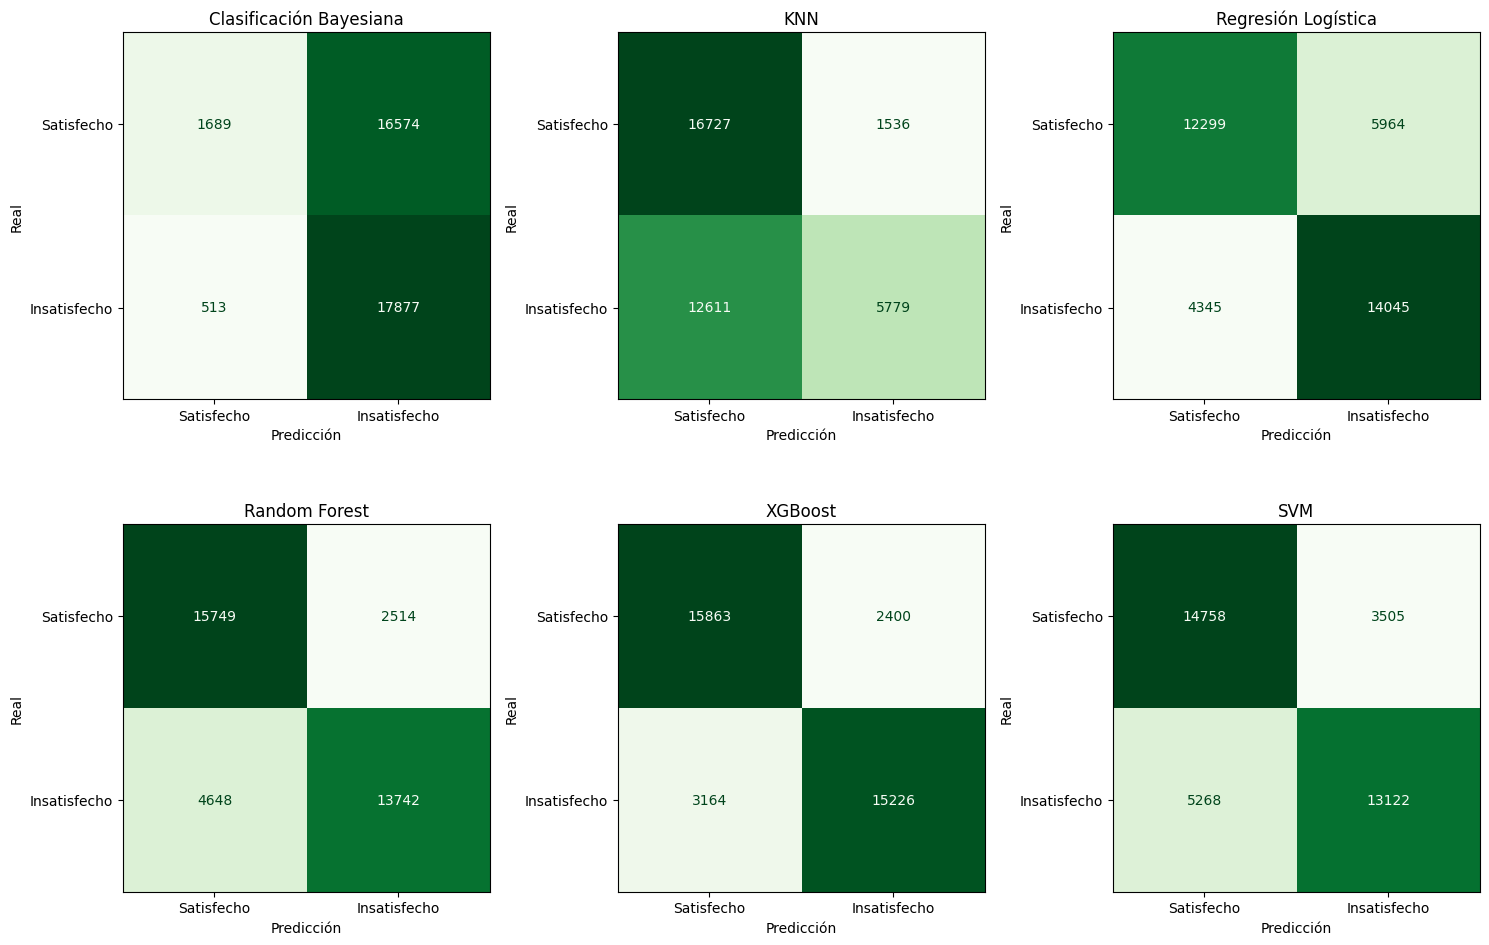

In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

models = {
        "Clasificación Bayesiana": bayes_gridsearch.predict(X_test_res),
        "KNN": knn_gridsearch.predict(X_test_res),
        "Regresión Logística": lr_gridsearch.predict(X_test_res),
        "Random Forest": rf_gridsearch.predict(X_test_res),
        "XGBoost": xgb_gridsearch.predict(X_test_res),
        "SVM": svm_gridsearch.predict(X_test_res)
}

cliente = ["Satisfecho", "Insatisfecho"]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, predictions) in enumerate(models.items()):
    cm = confusion_matrix(y_test_res, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cliente)
    disp.plot(ax=axes[idx], colorbar=False, cmap='Greens')
    axes[idx].set_title(name)
    axes[idx].set_xlabel("Predicción")
    axes[idx].set_ylabel("Real")

plt.tight_layout()
plt.show()

- **Clasificación Bayesiana:**  Este modelo destaca por su capacidad para identificar correctamente a los verdaderos insatisfechos, con un total de `17877`. Sin embargo, comete errores al clasificar incorrectamente a `16574` verdaderos satisfechos como insatisfechos, lo que representa un alto número de falsos positivos y limita su efectividad general.

- **KNN:**  La mejor predicción de este modelo corresponde a los verdaderos satisfechos, con un valor de `16727`. No obstante, su principal debilidad radica en los insatisfechos, ya que clasifica incorrectamente a `12611` verdaderos insatisfechos como satisfechos y solo logra identificar correctamente a `5779` insatisfechos, lo que refleja un bajo rendimiento en esta clase.

- **Regresión Logística:**  Este modelo, al igual que la Clasificación Bayesiana, destaca en la predicción de los verdaderos insatisfechos, con un total de `14045`. Además, logra mantener bajos los valores de falsos positivos y falsos negativos. Su desempeño en la clasificación de verdaderos satisfechos también es sólido, con un valor de `12299`, lo que demuestra un balance aceptable entre las clases.

- **Random Forest:**  Este modelo sobresale en la predicción de los verdaderos satisfechos, con un total de `15749`, seguido de los verdaderos insatisfechos correctamente clasificados, con un valor de `13742`. Además, mantiene bajos los valores de falsos positivos y falsos negativos, lo que lo convierte en un modelo confiable y bien balanceado.

* **XGBoost:**  Este modelo supera a los demás en desempeño general, con las predicciones correctas más altas: `15863` verdaderos satisfechos y `15226` verdaderos insatisfechos. Además, tiene los valores más bajos de errores: `3164` falsos satisfechos y `2400` falsos insatisfechos. Este excelente balance entre las predicciones correctas e incorrectas lo posiciona como el mejor modelo para esta tarea.

* **SVM:**  Este modelo muestra un buen desempeño general, destacándose en la predicción de los verdaderos satisfechos, con un total de `14758`, y de los verdaderos insatisfechos, con `13122`. Sin embargo, presenta algunos errores, como `3505` falsos satisfechos  y `5268` falsos insatisfechos.


### **Curvas ROC**

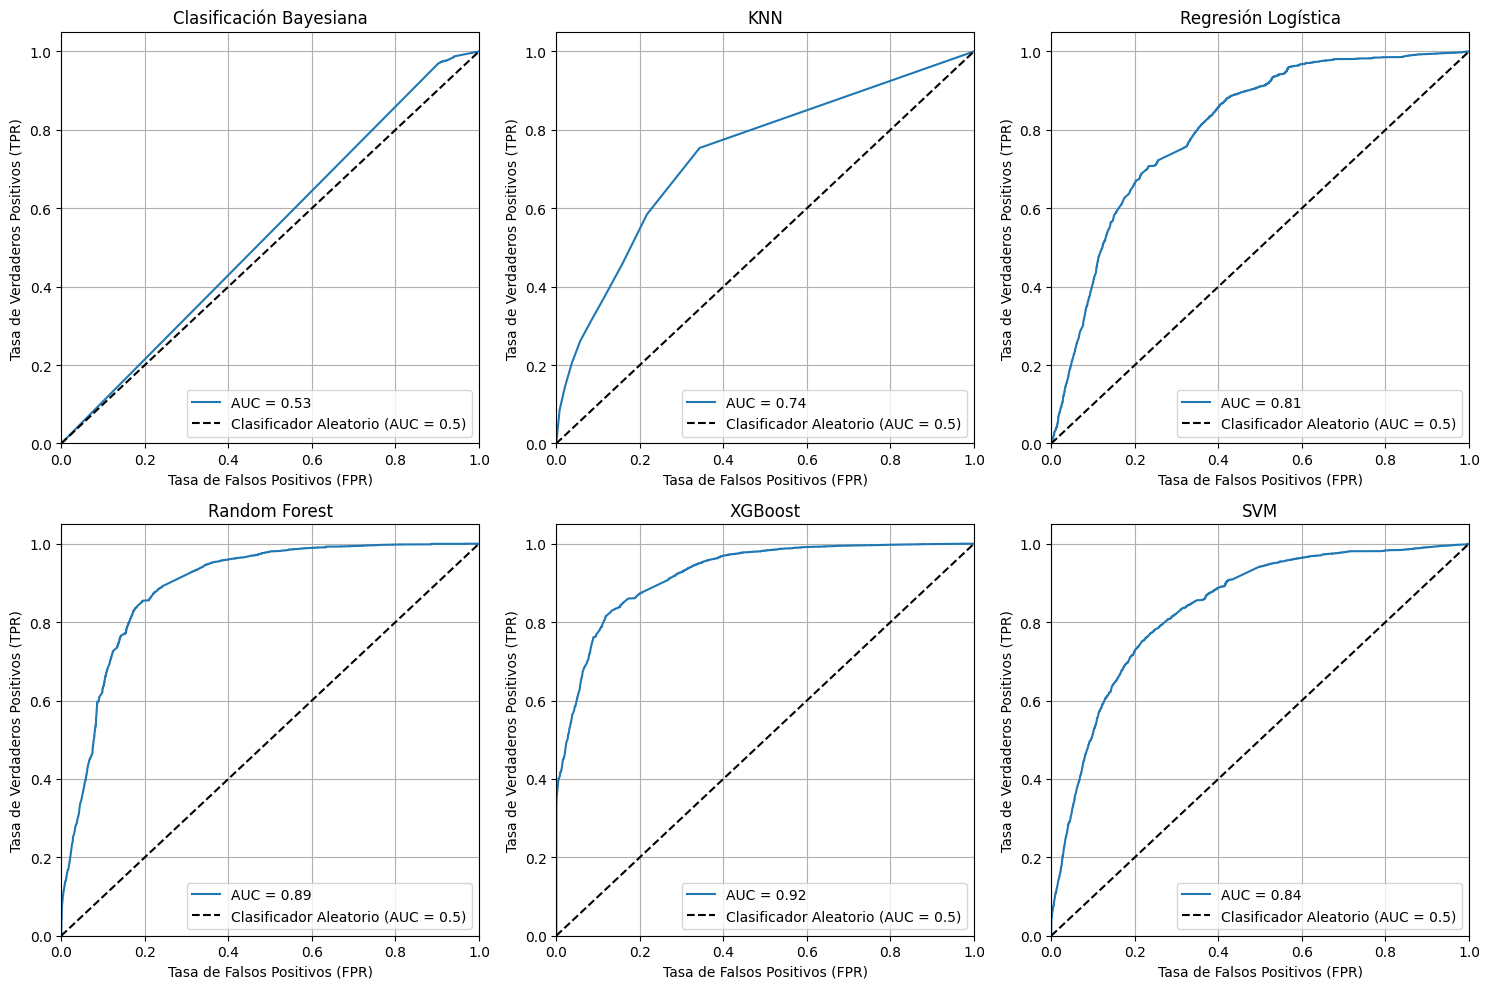

In [73]:
from sklearn.metrics import roc_curve, auc

# Probabilidades predichas de cada modelo
prob = {
    "Clasificación Bayesiana": bayes_gridsearch.predict_proba(X_test_res)[:, 1],
    "KNN": knn_gridsearch.predict_proba(X_test_res)[:, 1],
    "Regresión Logística": lr_gridsearch.predict_proba(X_test_res)[:, 1],
    "Random Forest": rf_gridsearch.predict_proba(X_test_res)[:, 1],
    "XGBoost": xgb_gridsearch.predict_proba(X_test_res)[:, 1],
    "SVM": svm_gridsearch.decision_function(X_test_res)
}

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Ajustar el tamaño según el número de modelos
axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

for idx, (name, y_pred_proba) in enumerate(prob.items()):
    fpr, tpr, thresholds = roc_curve(y_test_res, y_pred_proba)
    roc_auc = auc(fpr, tpr)  # Área bajo la curva ROC

    # Graficar la curva ROC en su respectiva subparcela
    axes[idx].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    axes[idx].plot([0, 1], [0, 1], 'k--', label="Clasificador Aleatorio (AUC = 0.5)")  # Línea base
    axes[idx].set_title(name)
    axes[idx].set_xlim([0.0, 1.0])
    axes[idx].set_ylim([0.0, 1.05])
    axes[idx].set_xlabel("Tasa de Falsos Positivos (FPR)")
    axes[idx].set_ylabel("Tasa de Verdaderos Positivos (TPR)")
    axes[idx].legend(loc="lower right")
    axes[idx].grid()

# Ajustar el diseño y ocultar subparcelas vacías si hay menos modelos que cuadrículas
for idx in range(len(prob), len(axes)):
    fig.delaxes(axes[idx])  # Eliminar ejes no utilizados

plt.tight_layout()
plt.show()

* **Clasificación Bayesiana:**  Al observar el valor obtenido para el AUC (`0.53`) comparado con el clasificador aleatorio (AUC = `0.5`) y la curva que se encuentra muy cercana a la diagonal, podemos concluir que este modelo presenta un rendimiento significativamente bajo. Es decir que se puede interpretar como si realizara predicciones al azar.

* **KNN:**  En este caso, aunque el AUC (`0.74`) de este modelo es ligeramente mayor y la curva está algo más alejada de la diagonal en comparación con un clasificador aleatorio, los valores siguen siendo bajos para el rendimiento deseado. Esto indica que, aunque hay una mejora, la capacidad del modelo para distinguir entre las clases sigue siendo insuficiente para considerarlo adecuado.

* **Regresión Logística:** El AUC de este modelo, igual a `0.81`, junto con la curva claramente alejada de la diagonal, indica un rendimiento significativamente mejor. Este valor implica que el modelo tiene una buena capacidad para distinguir entre las clases, aunque no es el mejor.

- **Random Forest:**  El **AUC** de este modelo, igual a **0.89**, junto con una curva bien separada de la diagonal, demuestra un excelente rendimiento. Esto indica que el modelo tiene una alta capacidad para distinguir entre las clases positivas y negativas.

- **XGBoost:**  Con un **AUC** de **0.92**, este modelo muestra el mejor desempeño entre todos los evaluados. La curva bien alejada de la diagonal refleja una capacidad excelente para discriminar entre las clases. Este resultado lo posiciona como el modelo más efectivo.

- **SVM:**  El **AUC** de este modelo, igual a **0.84**, junto con una curva separada de la diagonal, indica un buen rendimiento general. Aunque no alcanza los niveles de XGBoost o Random Forest, sigue siendo una opción competitiva.



## **PREDICCIÓN DE LA VARIABLE OBJETIVO**

El siguiente paso consiste en predecir la variable objetivo en el conjunto de datos denominado **test**, el cual, como es evidente, no incluye registros para la variable `TARGET`.

Sin embargo, antes de realizar esta predicción, es necesario filtrar el conjunto de datos **test** para que contenga las mismas variables que el conjunto de entrenamiento, garantizando así coherencia en el análisis.

In [82]:
from google.colab import drive
import pandas as pd

# Montar Google Drive
drive.mount('/content/drive')

# Especificar la ruta al archivo en tu Google Drive
file_path = '/content/drive/My Drive/test.csv'

# Cargar el archivo en un DataFrame
datatest = pd.read_csv(file_path)

# Visualiza los datos
datatest

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40532.100000
1,5,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45486.720000
2,6,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46993.950000
3,7,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187898.610000
4,9,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73649.730000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75813,151831,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40243.200000
75814,151832,2,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,146961.300000
75815,151833,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,167299.770000
75816,151834,2,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016


Ahora, utilizando la lista **contribuciones** generada luego de realizar análisis de multicolinealidad y PCA, obtenemos el siguiente conjunto de datos.

In [83]:
variablespca = contribucion.index.tolist()
variables = variablespca
datatestfinal = datatest[variables]
datatestfinal

,saldo_var5,ind_var30_0,saldo_medio_var12_hace3,var15,saldo_medio_var8_hace3,saldo_var14,saldo_medio_var5_hace2,num_var22_ult1,num_var37_med_ult2,imp_op_var41_efect_ult1,...,ind_var17_0,ind_var1_0,imp_trasp_var17_in_ult1,num_var17_0,delta_imp_trasp_var17_out_1y3,delta_imp_reemb_var17_1y3,saldo_var13_largo,num_op_var41_ult1,saldo_var30,num_var4
0,6.0,1,0.0,32,0.0,0.0,6.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0,6.0,1
1,3.0,1,0.0,35,0.0,0.0,3.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0,3.0,1
2,30.0,1,0.0,23,0.0,0.0,90.0,0,0,60.0,...,0,0,0.0,0,0,0,0.0,3,30.0,2
3,0.0,1,0.0,24,0.0,0.0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0,0.0,0
4,30.0,1,0.0,23,0.0,0.0,30.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0,30.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75813,0.0,1,0.0,23,0.0,0.0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0,0.0,0
75814,3.0,1,0.0,26,0.0,0.0,3.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0,3.0,1
75815,90.0,1,0.0,24,0.0,0.0,90.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0,90.0,1
75816,3.0,1,0.0,40,0.0,0.0,3.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0,3.0,1


Luego de hacer el respectivo filtrado, procedemos a hacer la predicción a partir del mejor modelo según los valores obtenidos en la métrica **ROC AUC**.

En nuestro caso, este modelo fue, como ya se mencionó anteriormente, **XGBoost**.

In [84]:
predicciontest = xgb_gridsearch.best_estimator_.predict(datatestfinal)
datatestfinal['TARGET'] = predicciontest

In [85]:
datatestfinal

,saldo_var5,ind_var30_0,saldo_medio_var12_hace3,var15,saldo_medio_var8_hace3,saldo_var14,saldo_medio_var5_hace2,num_var22_ult1,num_var37_med_ult2,imp_op_var41_efect_ult1,...,ind_var1_0,imp_trasp_var17_in_ult1,num_var17_0,delta_imp_trasp_var17_out_1y3,delta_imp_reemb_var17_1y3,saldo_var13_largo,num_op_var41_ult1,saldo_var30,num_var4,TARGET
0,6.0,1,0.0,32,0.0,0.0,6.0,0,0,0.0,...,0,0.0,0,0,0,0.0,0,6.0,1,0
1,3.0,1,0.0,35,0.0,0.0,3.0,0,0,0.0,...,0,0.0,0,0,0,0.0,0,3.0,1,1
2,30.0,1,0.0,23,0.0,0.0,90.0,0,0,60.0,...,0,0.0,0,0,0,0.0,3,30.0,2,0
3,0.0,1,0.0,24,0.0,0.0,0.0,0,0,0.0,...,0,0.0,0,0,0,0.0,0,0.0,0,0
4,30.0,1,0.0,23,0.0,0.0,30.0,0,0,0.0,...,0,0.0,0,0,0,0.0,0,30.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75813,0.0,1,0.0,23,0.0,0.0,0.0,0,0,0.0,...,0,0.0,0,0,0,0.0,0,0.0,0,1
75814,3.0,1,0.0,26,0.0,0.0,3.0,0,0,0.0,...,0,0.0,0,0,0,0.0,0,3.0,1,0
75815,90.0,1,0.0,24,0.0,0.0,90.0,0,0,0.0,...,0,0.0,0,0,0,0.0,0,90.0,1,0
75816,3.0,1,0.0,40,0.0,0.0,3.0,0,0,0.0,...,0,0.0,0,0,0,0.0,0,3.0,1,0


Finalmente observamos que se añadió la columna `TARGET`con el valor respectivo correspondiente a la predicción realizada a partir del modelo de clasificación **XGBoost**.